In [1]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import LSTM, Dense
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
data_b_NO2=pd.read_excel("/content/NO2_Data.xlsx",sheet_name='London')

In [3]:
df_b_NO2=data_b_NO2.groupby('Year').agg(NO2_Birmingham=('Annual_Mean', 'mean')).reset_index()

In [4]:
from itertools import count
data = df_b_NO2['NO2_Birmingham'].values.reshape(-1, 1)

# Normalize the data using MinMaxScaler
scaler = MinMaxScaler()
data_scaled = scaler.fit_transform(data)

# Define the number of time steps for the LSTM model
n_steps = 3  # You can adjust this based on your data and desired sequence length

In [5]:
# Create sequences for training
X = []
y = []
for i in range(n_steps, len(data_scaled)):
    X.append(data_scaled[i - n_steps:i, 0])
    y.append(data_scaled[i, 0])
X, y = np.array(X), np.array(y)

In [6]:
X = X.reshape(X.shape[0], X.shape[1], 1)

In [7]:
model = Sequential()
model.add(LSTM(units=30, activation='relu', input_shape=(X.shape[1], 1)))
model.add(Dense(units=1))
model.compile(optimizer='adam', loss='mse')

In [8]:
# Train the model
model.fit(X, y, epochs=100, batch_size=16)

Epoch 1/100
2/2 [==============================] - 2s 16ms/step - loss: 0.4408
Epoch 2/100
2/2 [==============================] - 0s 8ms/step - loss: 0.4303
Epoch 3/100
2/2 [==============================] - 0s 8ms/step - loss: 0.4198
Epoch 4/100
2/2 [==============================] - 0s 7ms/step - loss: 0.4090
Epoch 5/100
2/2 [==============================] - 0s 9ms/step - loss: 0.3994
Epoch 6/100
2/2 [==============================] - 0s 7ms/step - loss: 0.3890
Epoch 7/100
2/2 [==============================] - 0s 7ms/step - loss: 0.3788
Epoch 8/100
2/2 [==============================] - 0s 7ms/step - loss: 0.3691
Epoch 9/100
2/2 [==============================] - 0s 6ms/step - loss: 0.3593
Epoch 10/100
2/2 [==============================] - 0s 7ms/step - loss: 0.3498
Epoch 11/100
2/2 [==============================] - 0s 6ms/step - loss: 0.3408
Epoch 12/100
2/2 [==============================] - 0s 7ms/step - loss: 0.3319
Epoch 13/100
2/2 [==============================] - 0s 7ms/s

In [9]:
forecast_steps = 3
last_sequence = data_scaled[-n_steps:]
forecasted_values_scaled = []
for _ in range(forecast_steps):
    forecast_input = last_sequence.reshape(1, n_steps, 1)
    forecast = model.predict(forecast_input)[0, 0]
    forecasted_values_scaled.append(forecast)
    last_sequence = np.append(last_sequence[1:], forecast).reshape(-1, 1)

# Inverse transform the forecasted values
forecasted_values = scaler.inverse_transform(np.array(forecasted_values_scaled).reshape(-1, 1))

1/1 [==============================] - 0s 20ms/step


In [10]:
forecasted_years = np.arange(2023, 2023 + forecast_steps)
forecast_df = pd.DataFrame({'Year': forecasted_years, 'forecast': forecasted_values.flatten()})
forecast_df

,Year,forecast
0,2023,15.139785
1,2024,13.606494
2,2025,11.397394


In [11]:
extended_df = pd.concat([df_b_NO2, forecast_df], ignore_index=True)
extended_df

,Year,NO2_Birmingham,forecast
0,2000,51.000000,NaN
1,2001,49.111111,NaN
2,2002,44.833333,NaN
3,2003,52.941176,NaN
4,2004,50.333333,NaN
5,2005,50.333333,NaN
6,2006,49.944444,NaN
7,2007,46.947368,NaN
8,2008,46.636364,NaN
9,2009,46.636364,NaN


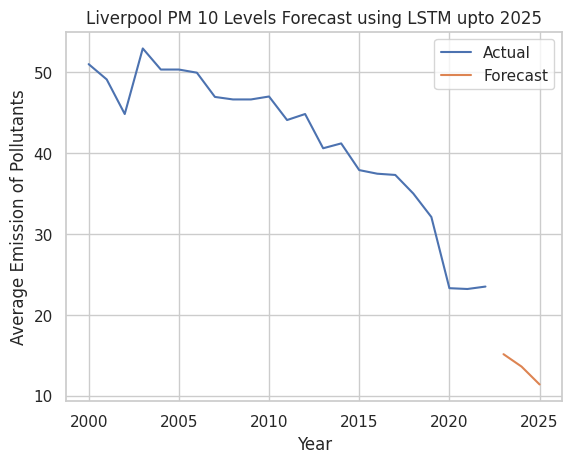

In [12]:
sns.set(style="whitegrid")
#plt.figure(figsize=(10, 6))
sns.lineplot(data=extended_df, x='Year', y='NO2_Birmingham', label='Actual')
sns.lineplot(data=extended_df, x='Year', y='forecast', label='Forecast')
plt.xlabel('Year')
plt.ylabel('Average Emission of Pollutants')
plt.title('Liverpool PM 10 Levels Forecast using LSTM upto 2025')
plt.legend()
plt.show()

In [13]:
import scipy.stats as stats

# Calculate the mean and standard error of the forecasted values
mean_forecast = np.mean(forecasted_values)
std_deviation = np.std(forecasted_values)
standard_error = std_deviation / np.sqrt(len(forecasted_values))

# Choose confidence level (e.g., 95%)
confidence_level = 0.95

# Calculate Z-score for the chosen confidence level
z_score = stats.norm.ppf(1 - (1 - confidence_level) / 2)

# Calculate confidence interval
lower_bound = mean_forecast - z_score * standard_error
upper_bound = mean_forecast + z_score * standard_error

print(f"Mean Forecast: {mean_forecast:.2f}")
print(f"Standard Error: {standard_error:.2f}")
print(f"Confidence Interval: ({lower_bound:.2f}, {upper_bound:.2f})")

Mean Forecast: 13.38
Standard Error: 0.89
Confidence Interval: (11.64, 15.12)


In [ ]:
#from google.colab import files

#csv_file_path = '/content/LSTM_Liverpool_PM10.csv'

#extended_df.to_csv(csv_file_path, index=True)

#files.download(csv_file_path)

Mean Forecast: 9.57
Standard Error: 0.02
Confidence Interval: (9.53, 9.61)


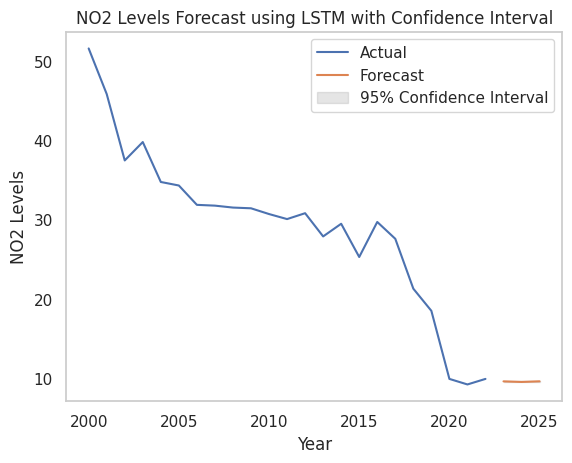

In [ ]:
import scipy.stats as stats

# Calculate the mean and standard error of the forecasted values
mean_forecast = np.mean(forecasted_values)
std_deviation = np.std(forecasted_values)
standard_error = std_deviation / np.sqrt(len(forecasted_values))

# Choose confidence level (e.g., 95%)
confidence_level = 0.95

# Calculate Z-score for the chosen confidence level
z_score = stats.norm.ppf(1 - (1 - confidence_level) / 2)

# Calculate confidence interval
lower_bound = mean_forecast - z_score * standard_error
upper_bound = mean_forecast + z_score * standard_error

print(f"Mean Forecast: {mean_forecast:.2f}")
print(f"Standard Error: {standard_error:.2f}")
print(f"Confidence Interval: ({lower_bound:.2f}, {upper_bound:.2f})")

# Plot the data and forecast with confidence interval
plt.plot(extended_df['Year'], extended_df['NO2_Birmingham'], label='Actual')
plt.plot(extended_df['Year'], extended_df['forecast'], label='Forecast')
plt.fill_between(
    forecasted_years,
    lower_bound,
    upper_bound,
    color='gray',
    alpha=0.2,
    label=f'{confidence_level*100:.0f}% Confidence Interval'
)
plt.xlabel('Year')
plt.ylabel('NO2 Levels')
plt.title('NO2 Levels Forecast using LSTM with Confidence Interval')
plt.grid()
plt.legend()
plt.show()


In [14]:
from sklearn.metrics import r2_score, mean_squared_error
import math

# Make predictions on the original dataset for comparison
y_pred_scaled = model.predict(X)
y_pred = scaler.inverse_transform(y_pred_scaled)

# Calculate R2 score
r2 = r2_score(data[n_steps:], y_pred)
print(f'R2 Score: {r2:.4f}')

# Calculate RMSE
mse = mean_squared_error(data[n_steps:], y_pred)
rmse = math.sqrt(mse)
print(f'RMSE: {rmse:.4f}')


1/1 [==============================] - 0s 19ms/step
R2 Score: 0.9178
RMSE: 2.5966
